In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pandas import DataFrame, Series
import pims
# import pims_nd2
import trackpy as tp
from pims import ND2_Reader
from skimage import io, exposure, util, measure, feature, filters, data, morphology, color, transform, draw, segmentation
from scipy import ndimage, misc, signal, spatial, stats, fftpack
# import cv2
from matplotlib import animation, rc, quiver
import matplotlib.patches as mpatches
from matplotlib import collections as mc
from IPython.display import HTML
import trackpy as tp
import sys
#sys.path.append('C://Users/ghosh135/Documents/Github/frst_python/frst/')
from mpl_toolkits import mplot3d
#from sklearn.preprocessing import normalize
from sklearn import preprocessing
import seaborn as sns

#import frst as frst
%matplotlib inline

In [3]:
loadf1 = io.imread('R://Dip/DNA_chain/fluorescent/00900.tif')
frames1 = np.asarray(loadf1)

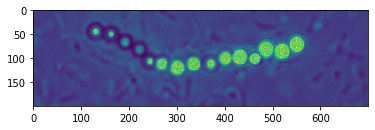

In [4]:
roi = loadf1[200:400, 200:900]
plt.imshow(roi)

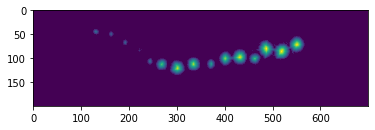

In [6]:
isod = roi > filters.threshold_isodata(roi) # isodata method thresholding
dist_isod = ndimage.distance_transform_edt(isod) # distance transform
plt.imshow(dist_isod)

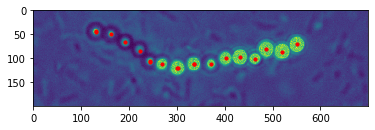

In [7]:
# min_distance is minimum distance between local maxima
coordinates_transform = feature.peak_local_max(dist_isod, min_distance=17)
plt.imshow(roi)
plt.scatter(coordinates_transform[:,1], coordinates_transform[:,0], s = 10, c = 'r')

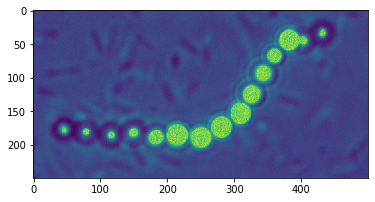

In [4]:
# now for the next one, there are two almost overlapping spheres
# to deal with that, we introduce a mask, and also reduce the 
# distance between peaks
image_2 = io.imread('R://Dip/DNA_chain/fluorescent/01217.tif')
arr_image2 = np.asarray(image_2)
plt.imshow(arr_image2[200:450, 300:800])

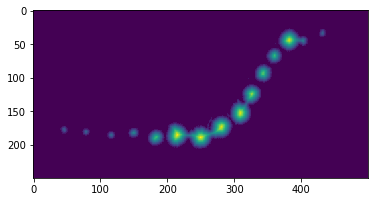

In [95]:
#this part is same as the previous one
roi2 = arr_image2[200:450, 300:800]
isod2 = roi2 > filters.threshold_isodata(roi2)
dist_isod2 = ndimage.distance_transform_edt(isod2)
plt.imshow(dist_isod2)

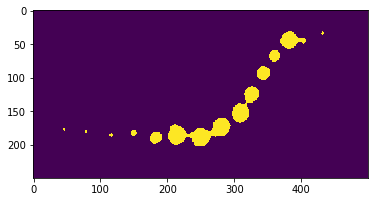

In [96]:
# this mask part is new
# the mask takes care of peaks outside the chain
thresh_isd = filters.threshold_isodata(dist_isod2)
mask2 = dist_isod2 > thresh_isd
plt.imshow(mask2)

In [97]:
thresh_isd

3.878038753069971

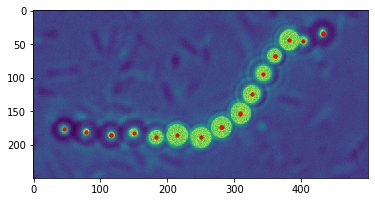

In [11]:
# the distance between peaks has been reduced
# as the particles are overlapping
coordinates_transform2 = feature.peak_local_max(dist_isod2*mask2, min_distance=7)
plt.imshow(roi2)
plt.scatter(coordinates_transform2[:,1], coordinates_transform2[:,0], s = 10, c = 'r')

In [91]:
t = tp.locate(image_2, 17, threshold=40, invert=False, minmass=1000, maxsize=35, separation=17)

In [57]:
t = t.loc[t.ecc<0.2]

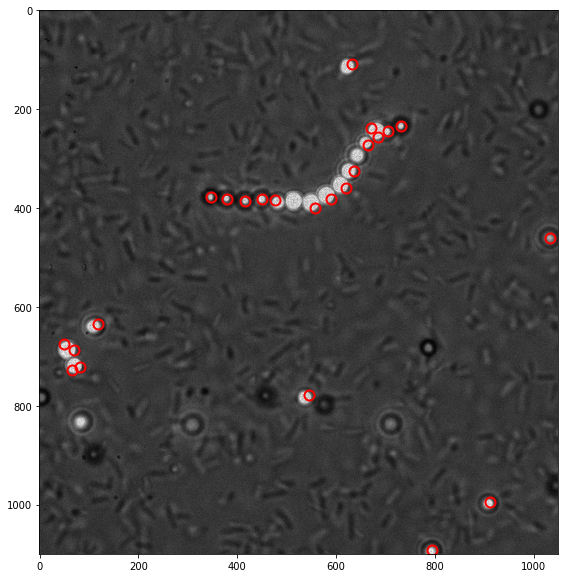

In [92]:
plt.figure(figsize=(10, 10))
tp.annotate(t, image_2, plot_style={'markersize': 10})

(array([5., 3., 0., 4., 2., 3., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2.,
        1., 0., 2.]),
 array([1428.38064624, 1754.00301389, 2079.62538155, 2405.24774921,
        2730.87011687, 3056.49248453, 3382.11485219, 3707.73721985,
        4033.35958751, 4358.98195517, 4684.60432282, 5010.22669048,
        5335.84905814, 5661.4714258 , 5987.09379346, 6312.71616112,
        6638.33852878, 6963.96089644, 7289.58326409, 7615.20563175,
        7940.82799941]),
 <a list of 20 Patch objects>)

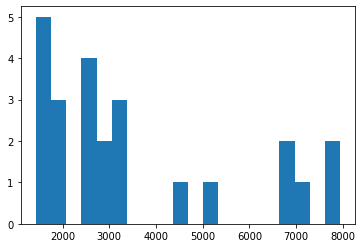

In [93]:
fig, ax = plt.subplots()
ax.hist(t['mass'], bins=20)

In [81]:
image_2.mean()

57.08740519480519

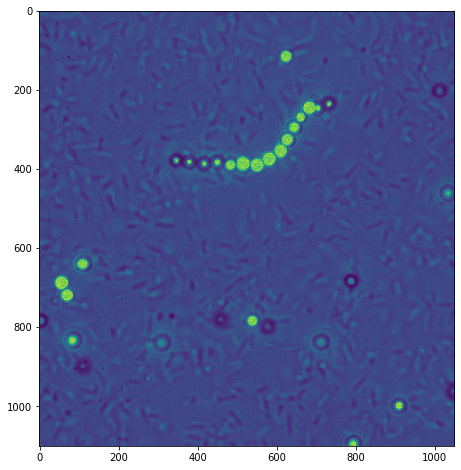

In [101]:
plt.figure(figsize=(8, 8))
plt.imshow(image_2)

In [106]:
thres1 = image_2 > filters.threshold_mean(image_2)
thres2 = image_2 > filters.threshold_isodata(image_2)
thres3 = image_2 > filters.threshold_local(image_2, 17)
thres4 = image_2 > filters.threshold_li(image_2)
thresList = [thres1, thres2, thres3, thres4]

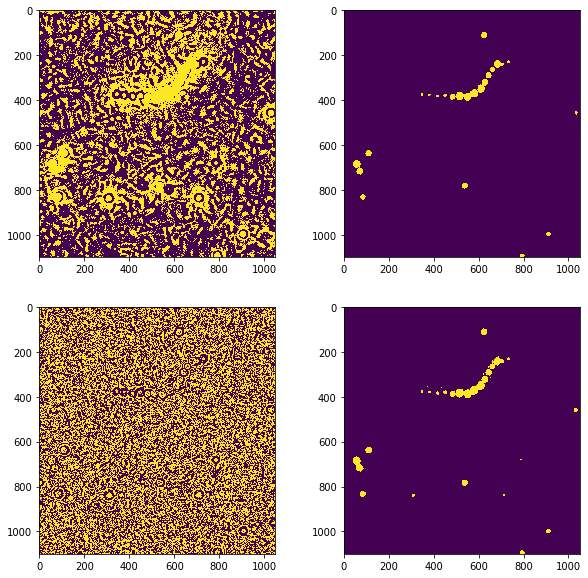

In [116]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for a, t in zip(np.squeeze(ax.reshape(1, 4)), thresList):
    a.imshow(t)

In [115]:
np.squeeze(ax.reshape(1, 4)).shape

(4,)

In [2]:
from myImageLib import dirrec
from IPython.display import clear_output, display

In [168]:
def proc(img):
    thres = filters.threshold_isodata(img)
    mask = img > thres
    dis_trans = ndimage.distance_transform_edt(mask)    
    masked = dis_trans * mask
    return masked
def masked_image(img):
    thres = filters.threshold_isodata(img)
    mask = img > thres
    masked = img * mask
    return masked
def distance_trans(img):
    dis_trans = ndimage.distance_transform_edt(img)
    return dis_trans
def locate_1(img):
    coords = feature.peak_local_max(img, min_distance=12)
    coords = pd.DataFrame(data=coords, columns=['y', 'x'])
    return coords
def annotate(img, coords):
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.scatter(coords.x, coords.y, s = 10, c = 'r')

In [227]:
def locate_s(sequence_dir):
    imgDirs = dirrec(sequence_dir, '*.tif')
    nameList = []
    dirList = []
    for imgDir in imgDirs:
        path, file = os.path.split(imgDir)
        name, ext = os.path.splitext(file)
        nameList.append(name)
        dirList.append(imgDir)
    fileList = pd.DataFrame()
    fileList = fileList.assign(Name=nameList, Dir=dirList)
    fileList = fileList.sort_values(by=['Name'])
    particles = pd.DataFrame()
    for num, imgDir in enumerate(fileList.Dir):
        if num > 400:
            continue
        clear_output(wait=True)
        print('Frame %d' % num)
        img = io.imread(imgDir)
#         img = mask_proc(img)
        dis_trans = proc(img)
        particle = locate_1(dis_trans)
        particle = particle.assign(frame=num)
        if len(particle) > 100:
            continue
        particles = particles.append(particle)
    return particles

In [170]:
masked = masked_image(image_2)
dis_trans = distance_trans(masked)
coords = locate_1(dis_trans)

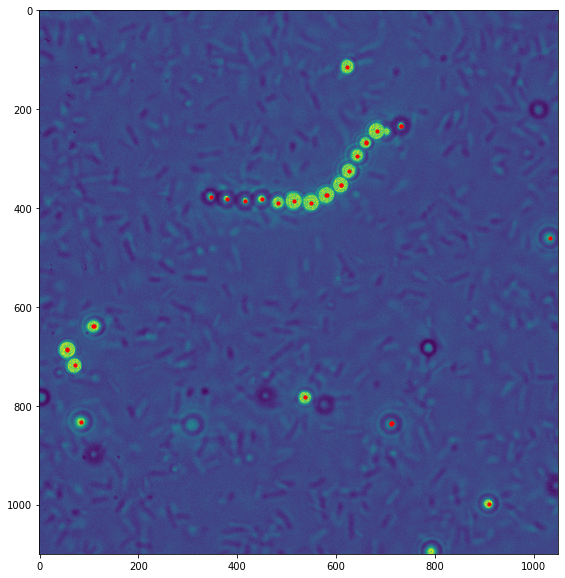

In [171]:
annotate(image_2, coords)

In [228]:
sequence_dir = r'R:\Dip\DNA_chain\fluorescent\4k bp, 10ug per ml_2'
particles = locate_s(sequence_dir)

Frame 400


In [213]:
particles.frame.drop_duplicates()

0    400
0    401
0    402
0    403
0    404
0    405
0    406
0    407
0    408
0    409
0    410
0    411
0    412
0    413
0    414
0    415
0    416
0    417
0    418
0    419
0    420
0    422
0    423
0    424
0    425
0    426
0    427
0    428
0    429
0    430
    ... 
0    566
0    567
0    568
0    569
0    570
0    571
0    572
0    573
0    574
0    575
0    576
0    577
0    578
0    579
0    581
0    583
0    584
0    587
0    589
0    590
0    591
0    592
0    593
0    594
0    595
0    596
0    597
0    598
0    599
0    600
Name: frame, Length: 181, dtype: int64

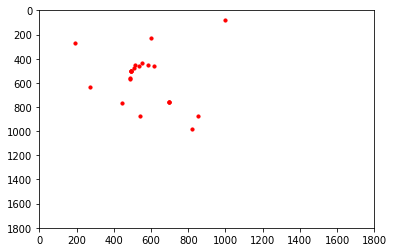

In [229]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.axis([0, 1800, 0, 1800])
for f in particles.frame.drop_duplicates():
    subdata = particles.loc[particles.frame==f]
    plt.axis([0, 1800, 1800, 0])
    plt.scatter(subdata.x, subdata.y, s = 10, c = 'r')
    plt.pause(.1)
    clear_output(wait=True)

In [26]:
particles.loc[particles.frame==501]

,y,x,frame
0,992,753,501
1,919,497,501
2,910,866,501
3,784,1024,501
4,585,292,501
5,584,293,501
6,551,490,501
7,520,511,501
8,496,616,501
9,489,524,501


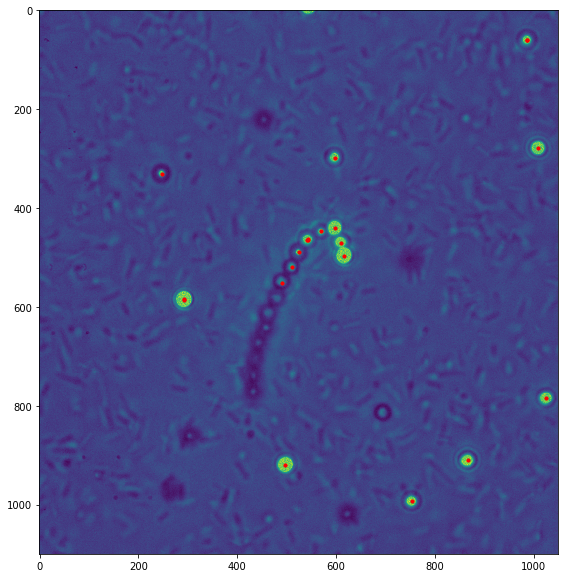

In [28]:
n = 501
t2 = particles.loc[particles.frame==n]
annotate(io.imread(os.path.join(sequence_dir, '%05d.tif'%n)), t2)

In [96]:
n

501

In [205]:
def mask_proc(img):
    f = filters.threshold_local(img, block_size=51)
    filtered = img > f
    dilate = morphology.dilation(filtered)
    fill_hole = morphology.remove_small_objects(dilate, min_size=2000)
    inv = np.invert(fill_hole)
    plt.imshow(inv, cmap='gray')
    label_image = skimage.measure.label(inv)
    for region in skimage.measure.regionprops(label_image, intensity_image=inv, coordinates='rc'):
        if region.area < 7000 or region.area > 30000:
            continue
        r = region
#         print(region.area)
    mask = np.zeros(inv.shape)
    for coord in r.coords:
        mask[coord[0], coord[1]] = 1
    masked = img * mask
    return mask, masked


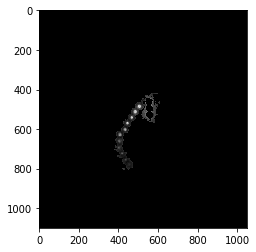

In [283]:
for i in range(400, 600):
    imgDir = r'R:\Dip\DNA_chain\fluorescent\4k bp, 10ug per ml_2\%05d.tif' % i
    img = io.imread(imgDir)
    masked = mask_proc(img)
    # dis_trans = proc(masked)
    # particle = locate_1(dis_trans)
    plt.imshow(masked, cmap='gray')
    plt.pause(.1)
    clear_output(wait=True)

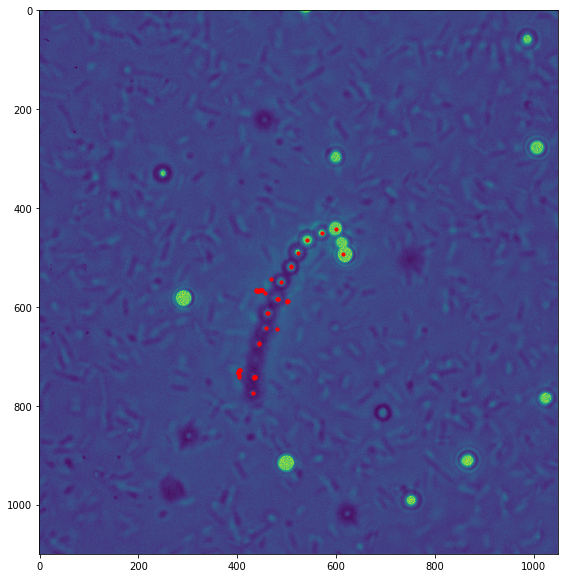

In [277]:
annotate(img, particle)

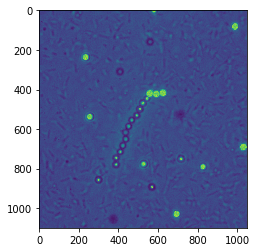

In [180]:
img = io.imread(os.path.join(sequence_dir, '%05d.tif'%n))
plt.imshow(img)

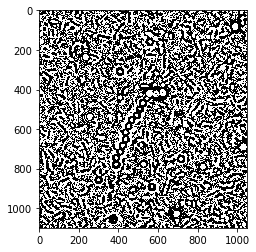

In [181]:
f = filters.threshold_local(img, block_size=51)
filtered = img > f
plt.imshow(filtered, cmap='gray')

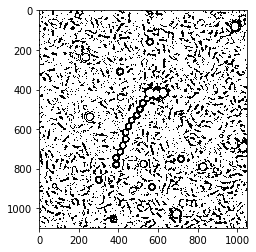

In [182]:
dilate = morphology.dilation(filtered)
plt.imshow(dilate, cmap='gray')

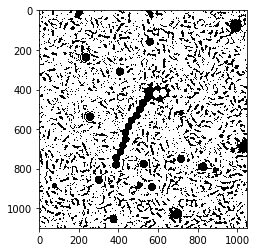

In [183]:
fill_hole = morphology.remove_small_objects(dilate, min_size=2000)
plt.imshow(fill_hole, cmap='gray')

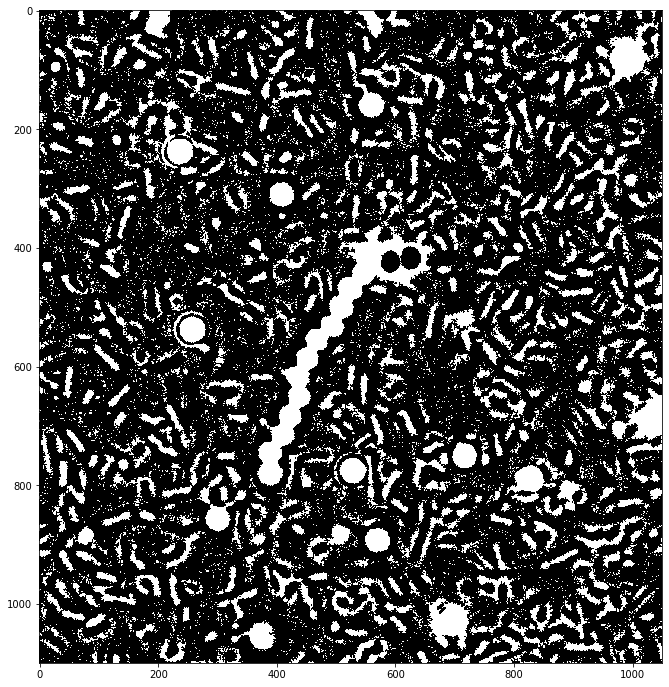

In [184]:
inv = np.invert(fill_hole)
plt.figure(figsize=(12, 12))
plt.imshow(inv, cmap='gray')

In [70]:
import skimage
import math
import skimage.data
import matplotlib.patches as mpatches

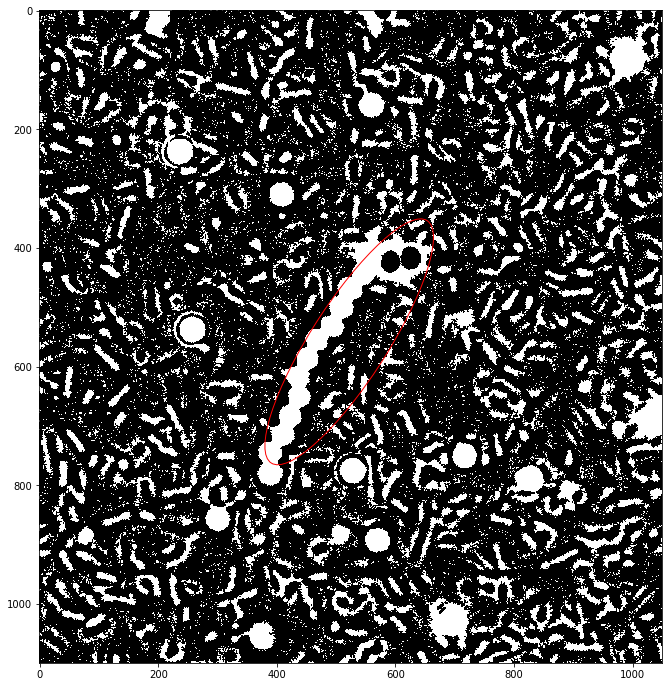

In [193]:
label_image = skimage.measure.label(inv)
for region in skimage.measure.regionprops(label_image, intensity_image=inv, coordinates='rc'):
    if region.area < 10000 or region.area > 20000:
        continue
    y, x = region.centroid
    width = region.major_axis_length
    height = region.minor_axis_length
    angle = region.orientation / math.pi * 180
    if angle < 0:
        angle = -angle + 90
    else:
        angle = 90 - angle
    r = region
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(inv, cmap='gray')
ax.add_patch(mpatches.Ellipse((x,y), width, height, angle, fc='none', ec='red'))

In [89]:
mask = np.zeros(inv.shape)

In [194]:
r.area

19239

In [119]:
for coord in r.coords:
    mask[coord[0], coord[1]] = 1

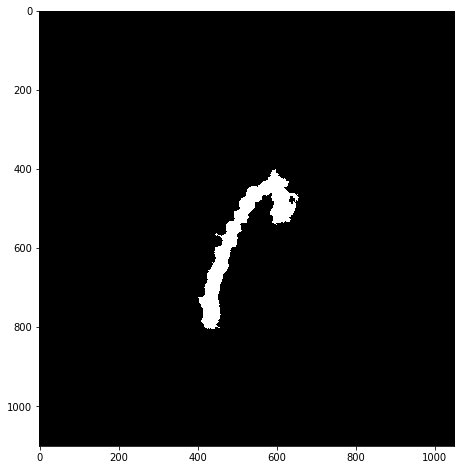

In [131]:
plt.figure(figsize=(8,8))
plt.imshow(mask, cmap='gray')

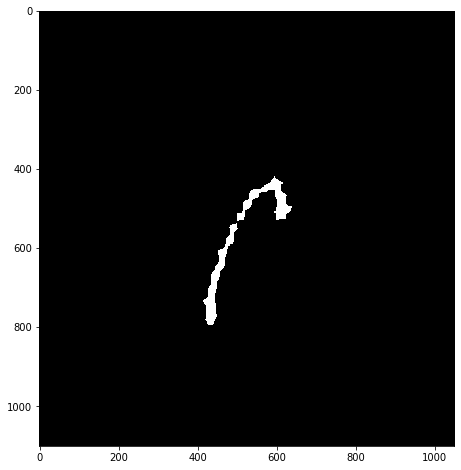

In [139]:
ero = morphology.erosion(mask, selem=np.ones((15,15)))
plt.figure(figsize=(8,8))
plt.imshow(ero, cmap='gray')

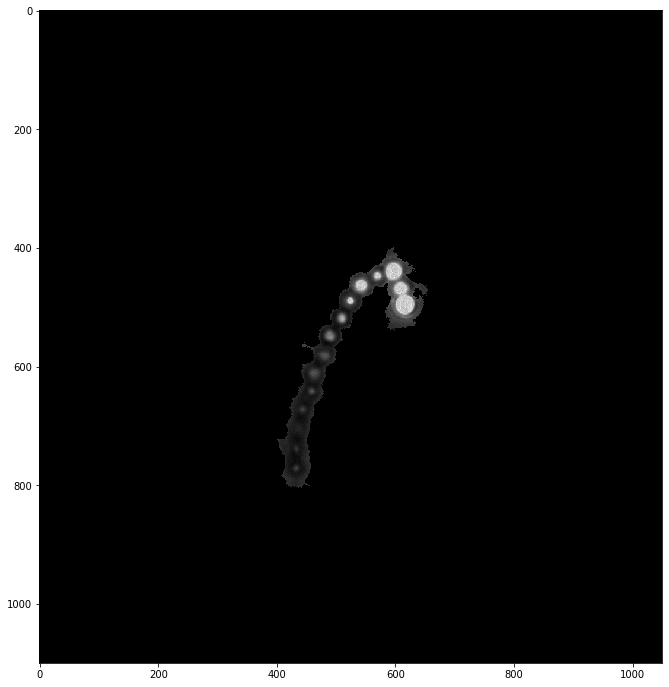

In [165]:
masked = img * mask
plt.figure(figsize=(12, 12))
plt.imshow(masked, cmap='gray')


In [169]:
dis_trans = proc(masked)
particle = locate_1(dis_trans)

In [232]:
from scipy.signal import medfilt2d, convolve2d, fftconvolve

In [268]:
def FastPeakFind(data):
    if str(data.dtype) != 'float32':
        data = data.astype('float32')
    mf = medfilt2d(data, kernel_size=15)
    mf = mf.astype('float32')
    thres = max(min(np.amax(mf,axis=0)), min(np.amax(mf,axis=1)))
    filt = matlab_style_gauss2D(shape=(31, 31))
    conv = convolve2d(mf, filt, mode='same')
    w_idx = conv > thres
    bw = conv.copy()
    bw[w_idx] = 1
    bw[~w_idx] = 0
    thresholded = np.multiply(bw, conv)
    edg = 3
    shape = data.shape
    idx = np.nonzero(thresholded[edg-1: shape[0]-edg-1, edg-1: shape[1]-edg-1])
    idx = np.transpose(idx)
    cent = []
    for xy in idx:
        x = xy[0]
        y = xy[1]
        if thresholded[x, y] >= thresholded[x-1, y-1] and \
            thresholded[x, y] > thresholded[x-1, y] and \
            thresholded[x, y] >= thresholded[x-1, y+1] and \
            thresholded[x, y] > thresholded[x, y-1] and \
            thresholded[x, y] > thresholded[x, y+1] and \
            thresholded[x, y] >= thresholded[x+1, y-1] and \
            thresholded[x, y] > thresholded[x+1, y] and \
            thresholded[x, y] >= thresholded[x+1, y+1]:
            cent.append(xy)
    cent = np.asarray(cent).transpose()
    return cent
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [272]:
cent = FastPeakFind(masked)
peaks = masked[cent[0], cent[1]]
ind = maxk(peaks, 15)
max_coor_tmp = cent[:, ind]
max_coor = max_coor_tmp.astype('float32')
max_coor = pd.DataFrame(data=max_coor.T, columns=['y', 'x'])

In [236]:
def maxk(array, num_max):
    """
    Return the indices of the largest (num_max) elements in array.
    Equivalent to MATLAB function maxk.
    """
    array = np.asarray(array)
    length = array.size
    array = array.reshape((1, length))
    idx = np.argsort(array)
    idx2 = np.flip(idx)
    return idx2[0, 0:num_max]

[300, 800, 900, 200]

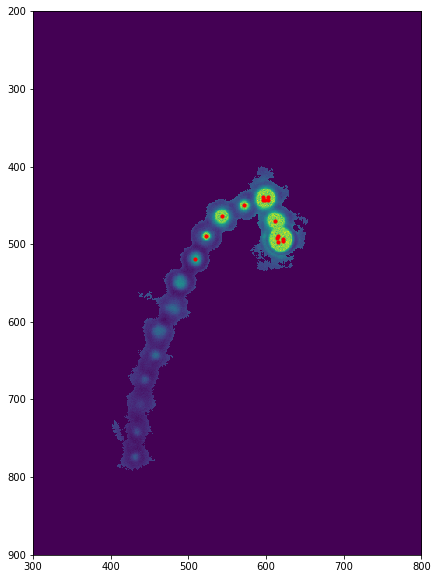

In [273]:
annotate(masked, max_coor)
plt.axis([300, 800, 900, 200])

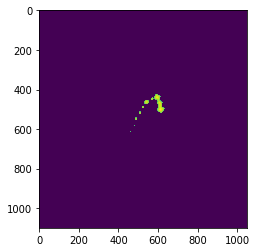

In [163]:
s_i = dis_trans/dis_trans.max()
plt.imshow(s_i**(1/8))

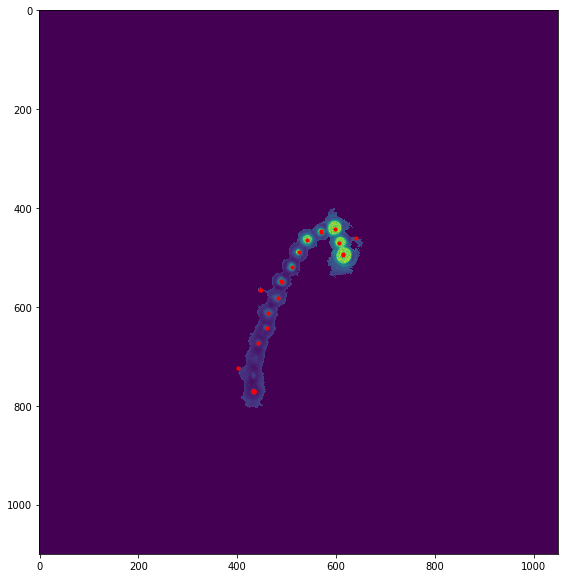

In [170]:
annotate(img * mask, particle)

In [201]:
for f in particles.frame.drop_duplicates():
    if len(particles.loc[particles.frame==f]) > 30:
        particles = particles.where(particles.frame!=f).dropna()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [202]:
particles = particles.loc[particles.frame < 500]

In [204]:
for f in particles.frame.drop_duplicates():
    if len(particles.loc[particles.frame==f]) > 30:
        print('Frame %d: %d' % (f, len(particles.loc[particles.frame==f])))

Frame 136: 33
Frame 138: 36
Frame 139: 35
Frame 142: 54
Frame 143: 34
Frame 144: 35
Frame 146: 33
Frame 147: 41
Frame 149: 35
Frame 151: 43
Frame 152: 36
Frame 153: 42
Frame 154: 39
Frame 155: 32
Frame 159: 32
Frame 160: 37
Frame 162: 35
Frame 164: 49
Frame 168: 35
Frame 171: 38
Frame 175: 36
Frame 179: 31
Frame 182: 32
Frame 184: 41
Frame 186: 34
Frame 189: 49
Frame 190: 31
Frame 191: 41
Frame 192: 31
Frame 196: 41
Frame 197: 33
Frame 198: 55
Frame 199: 33
Frame 200: 34
Frame 201: 32
Frame 203: 34
Frame 204: 59
Frame 205: 32
Frame 206: 38
Frame 207: 34
Frame 209: 57
Frame 210: 41
Frame 211: 35
Frame 212: 35
Frame 213: 31
Frame 214: 36
Frame 215: 35
Frame 217: 38
Frame 219: 32
Frame 221: 34
Frame 222: 32
Frame 224: 33
Frame 225: 37
Frame 228: 34
Frame 230: 41
Frame 231: 34
Frame 234: 42
Frame 239: 31
Frame 245: 31
Frame 246: 34
Frame 247: 38
Frame 250: 40
Frame 252: 32
Frame 258: 35
Frame 262: 33
Frame 266: 32
Frame 271: 36
Frame 272: 43
Frame 274: 45
Frame 275: 54
Frame 276: 44
Frame 